In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import random

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2

In [2]:
np.random.seed(0)

In [3]:
df_orig = pd.read_csv('../wf_df_raw.csv')

In [4]:
df = df_orig.copy()

In [5]:
df = df.dropna(subset=['img_name'])

In [6]:
df['series'] = df['series'].map(lambda x: x.replace(' ', '_'))

In [7]:
series_list = list(df['series'].value_counts()[:7].index)

In [8]:
series_list.sort()

In [9]:
BASE_DIR = os.path.dirname(os.getcwd())

RAW_IMGS_DIR = os.path.join(BASE_DIR, 'raw_images')

IMAGES_DIR = os.path.join(BASE_DIR, 'Images')
TRAINING_DIR = os.path.join(IMAGES_DIR, 'Training')
VALIDATION_DIR = os.path.join(IMAGES_DIR, 'Validation')

In [10]:
try:
    shutil.rmtree(IMAGES_DIR)
except: pass

os.mkdir(IMAGES_DIR)
os.mkdir(TRAINING_DIR)
os.mkdir(VALIDATION_DIR)

In [11]:
for series in series_list:
    os.mkdir(os.path.join(TRAINING_DIR, series))
    os.mkdir(os.path.join(VALIDATION_DIR, series))

In [12]:
for index, row in df.iterrows():
    
    CURR_IMG_DIR = os.path.join(RAW_IMGS_DIR, row['img_name'])
    
    random_number = np.random.randint(1,101)
    
    if row['series'] in series_list and random_number <= 80:
        shutil.copy(CURR_IMG_DIR, os.path.join(TRAINING_DIR, row['series']))
        
    elif row['series'] in series_list and random_number > 80:
        shutil.copy(CURR_IMG_DIR, os.path.join(VALIDATION_DIR, row['series']))

In [13]:
train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical'
)

Found 616 images belonging to 7 classes.


In [14]:
validation_datagen = ImageDataGenerator(rescale=1/255)

validation_generator = train_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical'
)

Found 155 images belonging to 7 classes.


In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              metrics=['accuracy'])

In [17]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15
)

Epoch 1/15
20/20 [==============================] - 20s 903ms/step - loss: 2.0308 - accuracy: 0.1443 - val_loss: 2.0609 - val_accuracy: 0.2774
Epoch 2/15
20/20 [==============================] - 17s 848ms/step - loss: 1.9638 - accuracy: 0.2397 - val_loss: 1.6522 - val_accuracy: 0.3613
Epoch 3/15
20/20 [==============================] - 17s 849ms/step - loss: 1.4793 - accuracy: 0.4190 - val_loss: 1.1432 - val_accuracy: 0.5484
Epoch 4/15
20/20 [==============================] - 17s 851ms/step - loss: 0.9553 - accuracy: 0.6480 - val_loss: 1.0661 - val_accuracy: 0.6387
Epoch 5/15
20/20 [==============================] - 17s 860ms/step - loss: 0.7941 - accuracy: 0.7332 - val_loss: 0.4447 - val_accuracy: 0.8710
Epoch 6/15
20/20 [==============================] - 17s 850ms/step - loss: 0.3852 - accuracy: 0.8711 - val_loss: 0.3377 - val_accuracy: 0.8968
Epoch 7/15
20/20 [==============================] - 17s 849ms/step - loss: 0.1759 - accuracy: 0.9535 - val_loss: 0.2528 - val_accuracy: 0.9290

In [18]:
model.evaluate(validation_generator)

5/5 [==============================] - 3s 663ms/step - loss: 0.1807 - accuracy: 0.9548


[0.18073809146881104, 0.9548386931419373]

In [19]:
pre_trained_model = tf.keras.applications.InceptionV3(
    include_top = False,
    weights = "imagenet",
    input_shape = (300, 300, 3)
)

In [20]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [21]:
last_layer = pre_trained_model.layers[-1]
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 8, 8, 2048)


In [22]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense(7, activation='softmax')(x)

In [23]:
model = tf.keras.models.Model(pre_trained_model.input, x)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size=32,
    epochs=30
)

Epoch 1/30
20/20 [==============================] - 24s 969ms/step - loss: 11.7701 - accuracy: 0.3177 - val_loss: 0.6746 - val_accuracy: 0.7548
Epoch 2/30
20/20 [==============================] - 18s 926ms/step - loss: 0.4266 - accuracy: 0.8744 - val_loss: 0.1442 - val_accuracy: 0.9613
Epoch 3/30
20/20 [==============================] - 18s 917ms/step - loss: 0.7547 - accuracy: 0.8637 - val_loss: 0.1912 - val_accuracy: 0.9290
Epoch 4/30
20/20 [==============================] - 18s 950ms/step - loss: 0.3541 - accuracy: 0.9265 - val_loss: 0.4667 - val_accuracy: 0.8323
Epoch 5/30
20/20 [==============================] - 18s 921ms/step - loss: 0.7410 - accuracy: 0.9066 - val_loss: 0.0815 - val_accuracy: 0.9742
Epoch 6/30
20/20 [==============================] - 18s 888ms/step - loss: 0.0527 - accuracy: 0.9964 - val_loss: 6.8497 - val_accuracy: 0.4194
Epoch 7/30
20/20 [==============================] - 18s 897ms/step - loss: 1.2437 - accuracy: 0.8474 - val_loss: 0.0823 - val_accuracy: 0.980

In [25]:
model.evaluate(validation_generator)

5/5 [==============================] - 4s 691ms/step - loss: 0.0903 - accuracy: 0.9806


[0.09025662392377853, 0.9806451797485352]

In [26]:
SERIES = random.choice(series_list)
SERIES_DIR = os.path.join(VALIDATION_DIR, SERIES)
WATCHES = os.listdir(SERIES_DIR)
WATCH = random.choice(WATCHES)
WATCH_DIR = os.path.join(SERIES_DIR, WATCH)

In [27]:
img = image.load_img(WATCH_DIR, target_size=(300, 300))
x = image.img_to_array(img)
x = x / 255.
x = np.expand_dims(x, axis=0)

prediction = model.predict(x)

Actual:		Formula_1
Predicted:	Formula_1


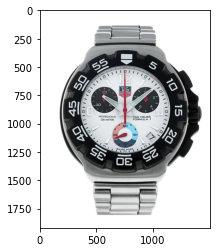

In [28]:
img_orig = cv2.imread(WATCH_DIR)[...,::-1]
imgplot = plt.imshow(img_orig)
print(f"Actual:\t\t{SERIES}\nPredicted:\t{series_list[np.argmax(prediction)]}")

In [29]:
correct = 0
n = 200

for i in range(n):
    SERIES = random.choice(series_list)
    SERIES_DIR = os.path.join(VALIDATION_DIR, SERIES)
    WATCHES = os.listdir(SERIES_DIR)
    WATCH = random.choice(WATCHES)
    WATCH_DIR = os.path.join(SERIES_DIR, WATCH)
    
    img = image.load_img(WATCH_DIR, target_size=(300, 300))
    x = image.img_to_array(img) / 255.
    x = np.expand_dims(x, axis=0)

    prediction = model.predict(x)
    
    if SERIES == series_list[np.argmax(prediction)]:
        correct += 1

print(round(100 * correct/n, 2))

98.0
